# Training FSRS on simulated data

Requirement: fsrs-optimizer >= 5.4.1

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2223


  0%|          | 0/2223 [00:00<?, ?it/s]

loss before: 0.3609, loss after: 0.3364
RMSE(bins): 0.0302
AUC: 0.5976
1.1596 -> 1.2028: SMAPE=3.6573%
1.7974 -> 2.7132: SMAPE=40.6066%
13.1205 -> 9.2016: SMAPE=35.1123%
49.3729 -> 26.042: SMAPE=61.8734%
7.2303 -> 7.2836: SMAPE=0.7345%
0.5081 -> 0.6857: SMAPE=29.7537%
1.5371 -> 1.4237: SMAPE=7.6601%
0.001 -> 0.0719: SMAPE=194.5130%
1.5052 -> 1.4595: SMAPE=3.0829%
0.1261 -> 0.2012: SMAPE=45.8906%
0.9735 -> 0.9401: SMAPE=3.4908%
1.8924 -> 1.8739: SMAPE=0.9824%
0.1486 -> 0.1811: SMAPE=19.7149%
0.2407 -> 0.2463: SMAPE=2.2998%
2.1937 -> 2.1674: SMAPE=1.2061%
0.1518 -> 0.1249: SMAPE=19.4434%
3.0699 -> 2.8026: SMAPE=9.1034%
Avg. SMAPE: 28.1838%
loss before: 0.3609, loss after: 0.3384
RMSE(bins): 0.0329
AUC: 0.5742
--------------------------------
learn_span: 60


sample size: 5325


  0%|          | 0/5325 [00:00<?, ?it/s]

loss before: 0.3586, loss after: 0.3329
RMSE(bins): 0.0239
AUC: 0.5681
1.1596 -> 1.0867: SMAPE=6.4907%
1.7974 -> 1.5955: SMAPE=11.9013%
13.1205 -> 12.5981: SMAPE=4.0624%
49.3729 -> 35.7758: SMAPE=31.9373%
7.2303 -> 7.1398: SMAPE=1.2596%
0.5081 -> 0.6078: SMAPE=17.8690%
1.5371 -> 1.4968: SMAPE=2.6566%
0.001 -> 0.0017: SMAPE=51.8519%
1.5052 -> 1.5836: SMAPE=5.0764%
0.1261 -> 0.4698: SMAPE=115.3549%
0.9735 -> 1.0819: SMAPE=10.5478%
1.8924 -> 1.9196: SMAPE=1.4271%
0.1486 -> 0.1052: SMAPE=34.2002%
0.2407 -> 0.2503: SMAPE=3.9104%
2.1937 -> 2.3749: SMAPE=7.9324%
0.1518 -> 0.0193: SMAPE=154.8802%
3.0699 -> 3.0628: SMAPE=0.2315%
Avg. SMAPE: 27.1523%
loss before: 0.3586, loss after: 0.3343
RMSE(bins): 0.0257
AUC: 0.5460
--------------------------------
learn_span: 120


sample size: 11740


  0%|          | 0/11740 [00:00<?, ?it/s]

loss before: 0.3585, loss after: 0.3372
RMSE(bins): 0.0192
AUC: 0.5749
1.1596 -> 1.1875: SMAPE=2.3774%
1.7974 -> 1.6228: SMAPE=10.2099%
13.1205 -> 13.0838: SMAPE=0.2801%
49.3729 -> 34.2093: SMAPE=36.2843%
7.2303 -> 7.0695: SMAPE=2.2490%
0.5081 -> 0.4723: SMAPE=7.3031%
1.5371 -> 1.9617: SMAPE=24.2712%
0.001 -> 0.0123: SMAPE=169.9248%
1.5052 -> 1.5061: SMAPE=0.0598%
0.1261 -> 0.2023: SMAPE=46.4068%
0.9735 -> 1.0156: SMAPE=4.2331%
1.8924 -> 1.875: SMAPE=0.9237%
0.1486 -> 0.1773: SMAPE=17.6128%
0.2407 -> 0.2494: SMAPE=3.5503%
2.1937 -> 2.3319: SMAPE=6.1075%
0.1518 -> 0.1303: SMAPE=15.2428%
3.0699 -> 3.007: SMAPE=2.0701%
Avg. SMAPE: 20.5357%
loss before: 0.3585, loss after: 0.3374
RMSE(bins): 0.0200
AUC: 0.5721
--------------------------------
learn_span: 240


sample size: 25558


  0%|          | 0/25558 [00:00<?, ?it/s]

loss before: 0.3486, loss after: 0.3315
RMSE(bins): 0.0159
AUC: 0.5660
1.1596 -> 1.0316: SMAPE=11.6831%
1.7974 -> 1.7236: SMAPE=4.1920%
13.1205 -> 13.8904: SMAPE=5.7007%
49.3729 -> 49.1623: SMAPE=0.4275%
7.2303 -> 6.9961: SMAPE=3.2925%
0.5081 -> 0.395: SMAPE=25.0471%
1.5371 -> 1.9811: SMAPE=25.2402%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.5803: SMAPE=4.8679%
0.1261 -> 0.2367: SMAPE=60.9702%
0.9735 -> 1.1105: SMAPE=13.1478%
1.8924 -> 1.8273: SMAPE=3.5003%
0.1486 -> 0.1956: SMAPE=27.3097%
0.2407 -> 0.2715: SMAPE=12.0266%
2.1937 -> 2.4582: SMAPE=11.3717%
0.1518 -> 0.1584: SMAPE=4.2553%
3.0699 -> 3.1556: SMAPE=2.7532%
Avg. SMAPE: 12.6933%
loss before: 0.3486, loss after: 0.3317
RMSE(bins): 0.0168
AUC: 0.5649
--------------------------------
learn_span: 480


sample size: 54050


  0%|          | 0/54050 [00:00<?, ?it/s]

loss before: 0.3483, loss after: 0.3340
RMSE(bins): 0.0124
AUC: 0.5612
1.1596 -> 1.1088: SMAPE=4.4789%
1.7974 -> 1.7623: SMAPE=1.9721%
13.1205 -> 14.2932: SMAPE=8.5556%
49.3729 -> 45.6342: SMAPE=7.8704%
7.2303 -> 7.0153: SMAPE=3.0185%
0.5081 -> 0.4668: SMAPE=8.4727%
1.5371 -> 1.512: SMAPE=1.6464%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4105: SMAPE=6.4959%
0.1261 -> 0.1429: SMAPE=12.4907%
0.9735 -> 1.021: SMAPE=4.7631%
1.8924 -> 1.8444: SMAPE=2.5690%
0.1486 -> 0.2012: SMAPE=30.0743%
0.2407 -> 0.2495: SMAPE=3.5904%
2.1937 -> 2.6262: SMAPE=17.9464%
0.1518 -> 0.1745: SMAPE=13.9136%
3.0699 -> 2.9156: SMAPE=5.1558%
Avg. SMAPE: 7.8243%
loss before: 0.3483, loss after: 0.3340
RMSE(bins): 0.0126
AUC: 0.5602
--------------------------------
learn_span: 960


sample size: 103355


  0%|          | 0/103355 [00:00<?, ?it/s]

loss before: 0.3408, loss after: 0.3301
RMSE(bins): 0.0106
AUC: 0.5517
1.1596 -> 1.1844: SMAPE=2.1160%
1.7974 -> 1.6805: SMAPE=6.7224%
13.1205 -> 13.0805: SMAPE=0.3053%
49.3729 -> 48.6341: SMAPE=1.5076%
7.2303 -> 7.0502: SMAPE=2.5223%
0.5081 -> 0.4748: SMAPE=6.7759%
1.5371 -> 1.7076: SMAPE=10.5094%
0.001 -> 0.0028: SMAPE=94.7368%
1.5052 -> 1.4028: SMAPE=7.0426%
0.1261 -> 0.1465: SMAPE=14.9670%
0.9735 -> 1.1367: SMAPE=15.4677%
1.8924 -> 1.7565: SMAPE=7.4488%
0.1486 -> 0.1546: SMAPE=3.9578%
0.2407 -> 0.2377: SMAPE=1.2542%
2.1937 -> 2.9195: SMAPE=28.3893%
0.1518 -> 0.1497: SMAPE=1.3930%
3.0699 -> 3.0008: SMAPE=2.2765%
Avg. SMAPE: 12.1996%
loss before: 0.3408, loss after: 0.3301
RMSE(bins): 0.0105
AUC: 0.5534
--------------------------------


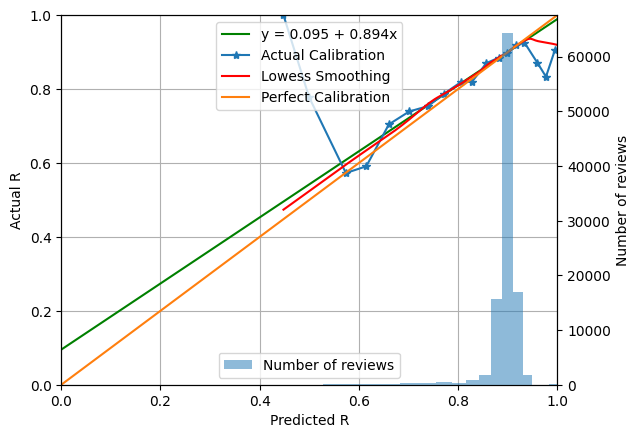

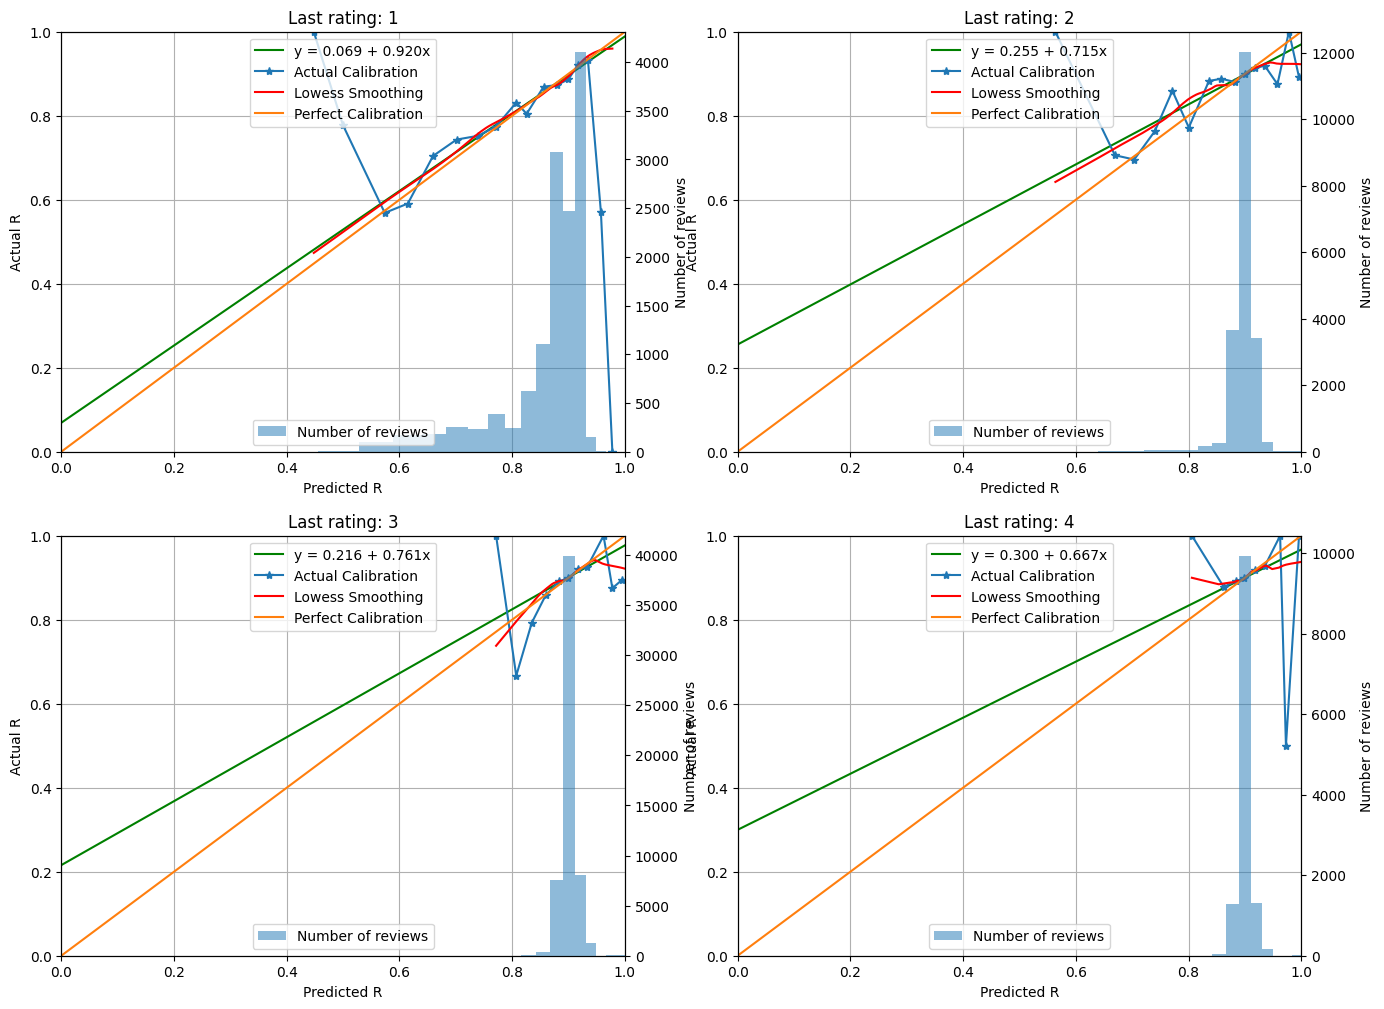

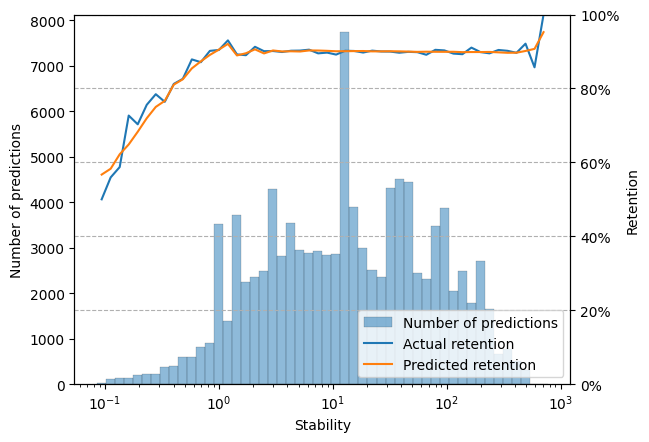

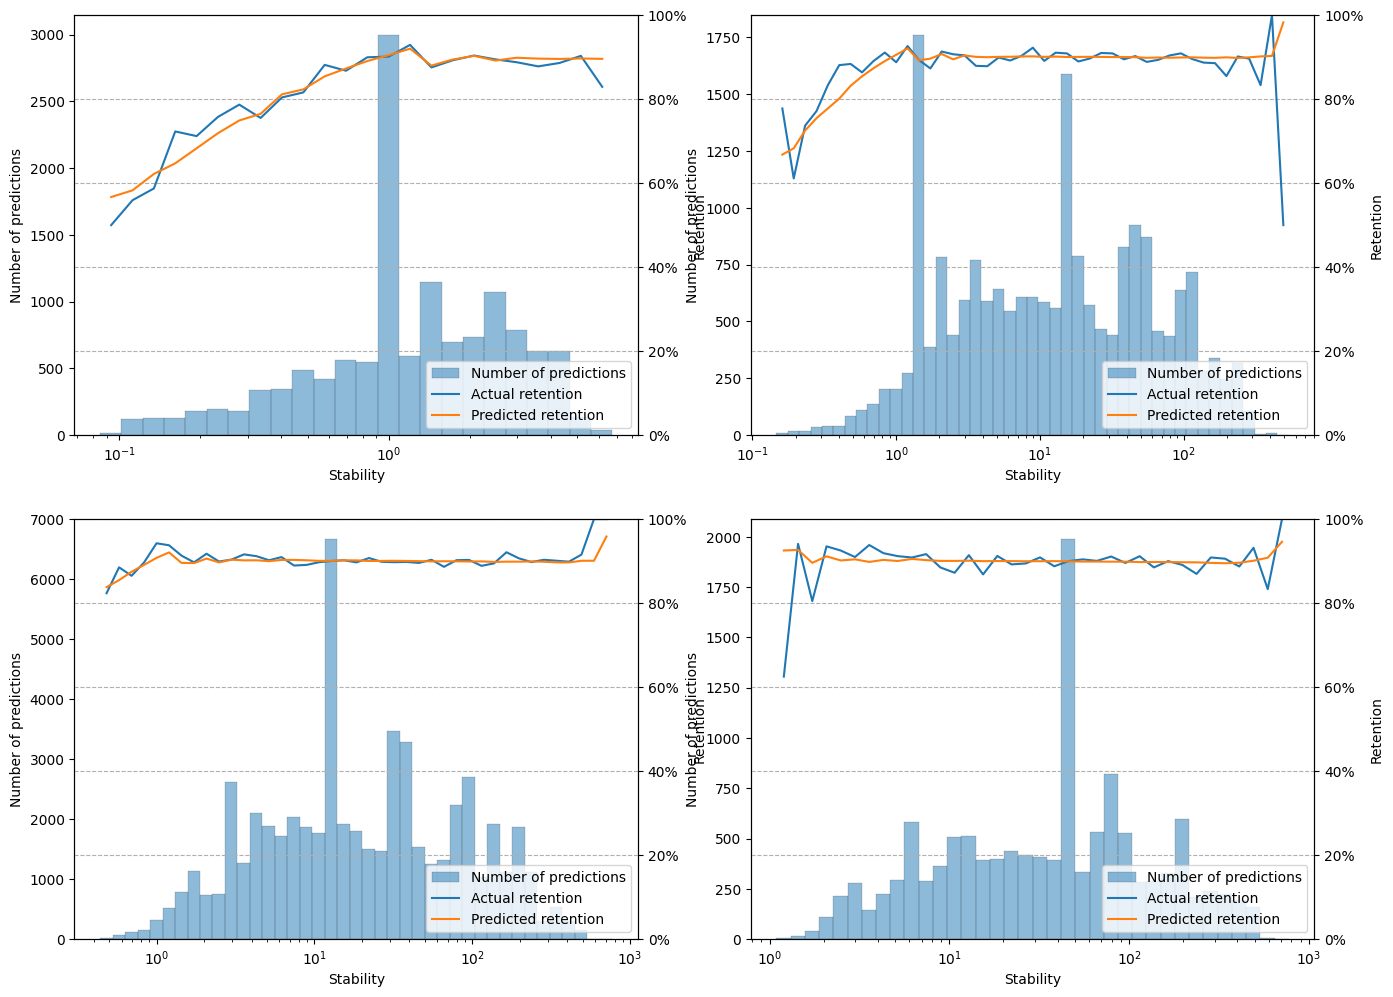

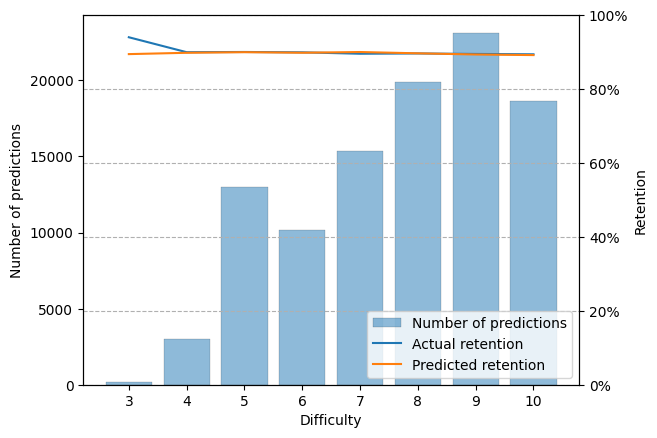

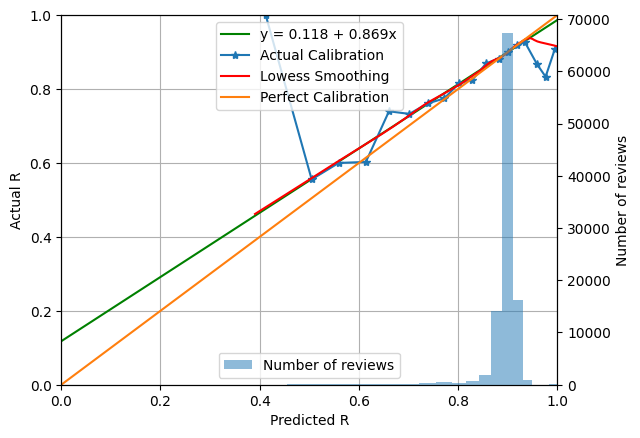

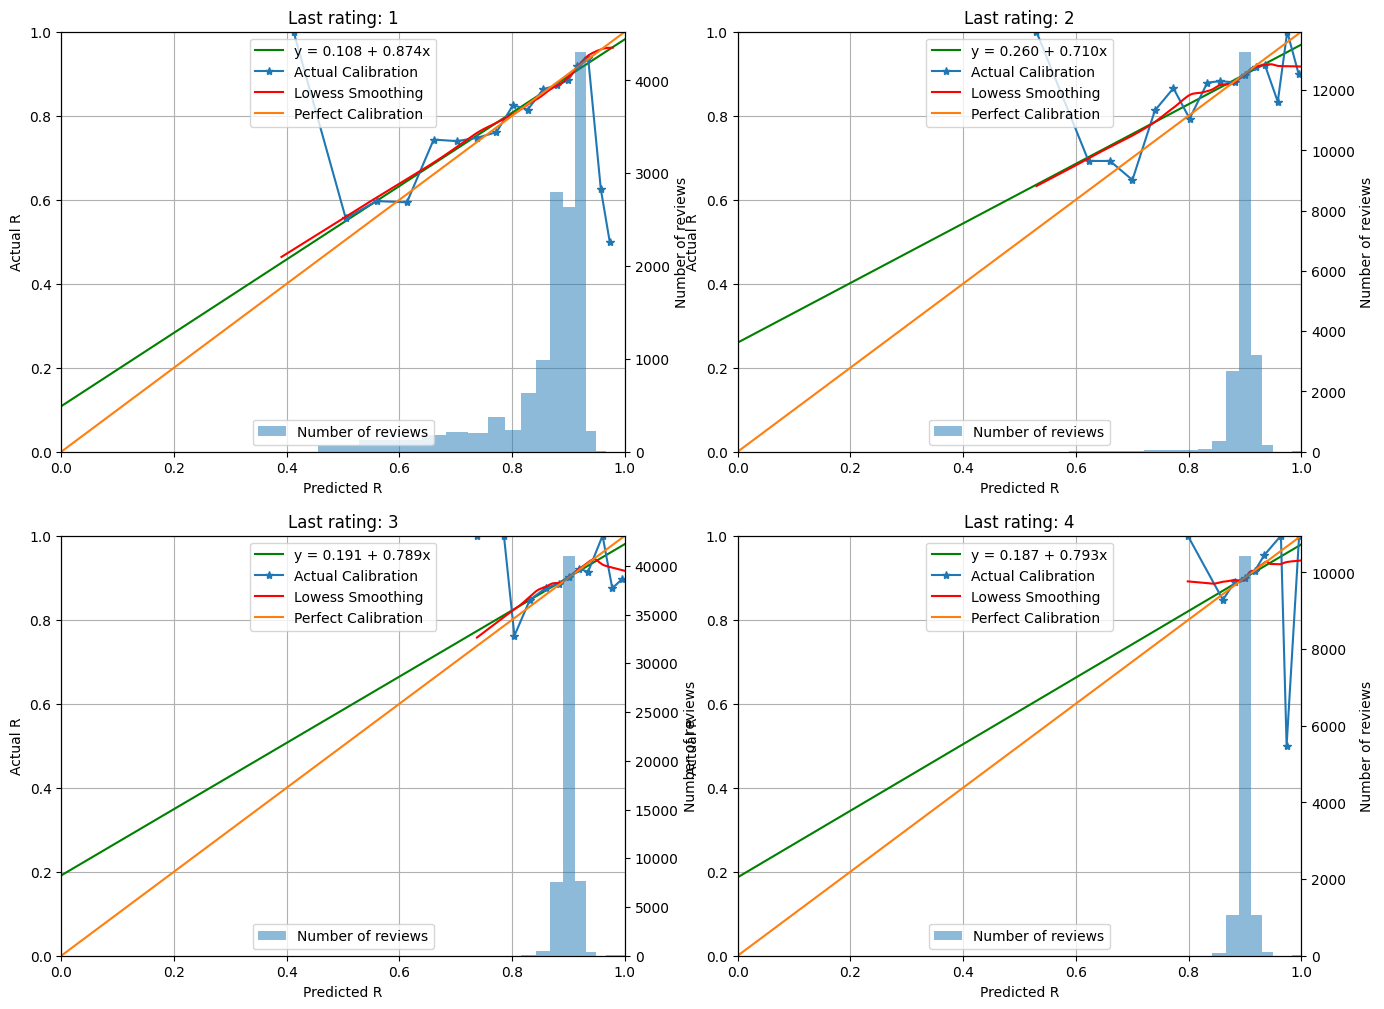

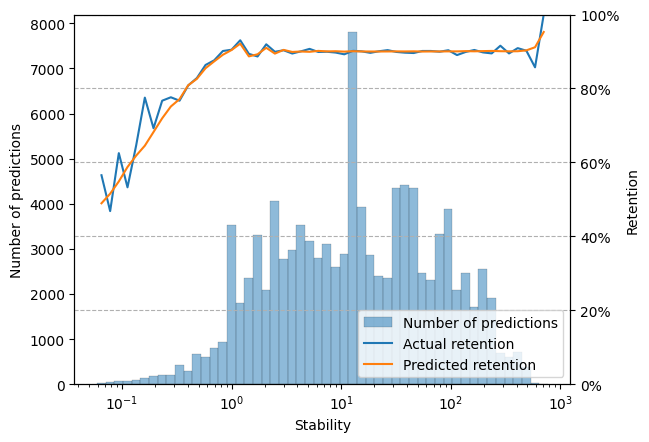

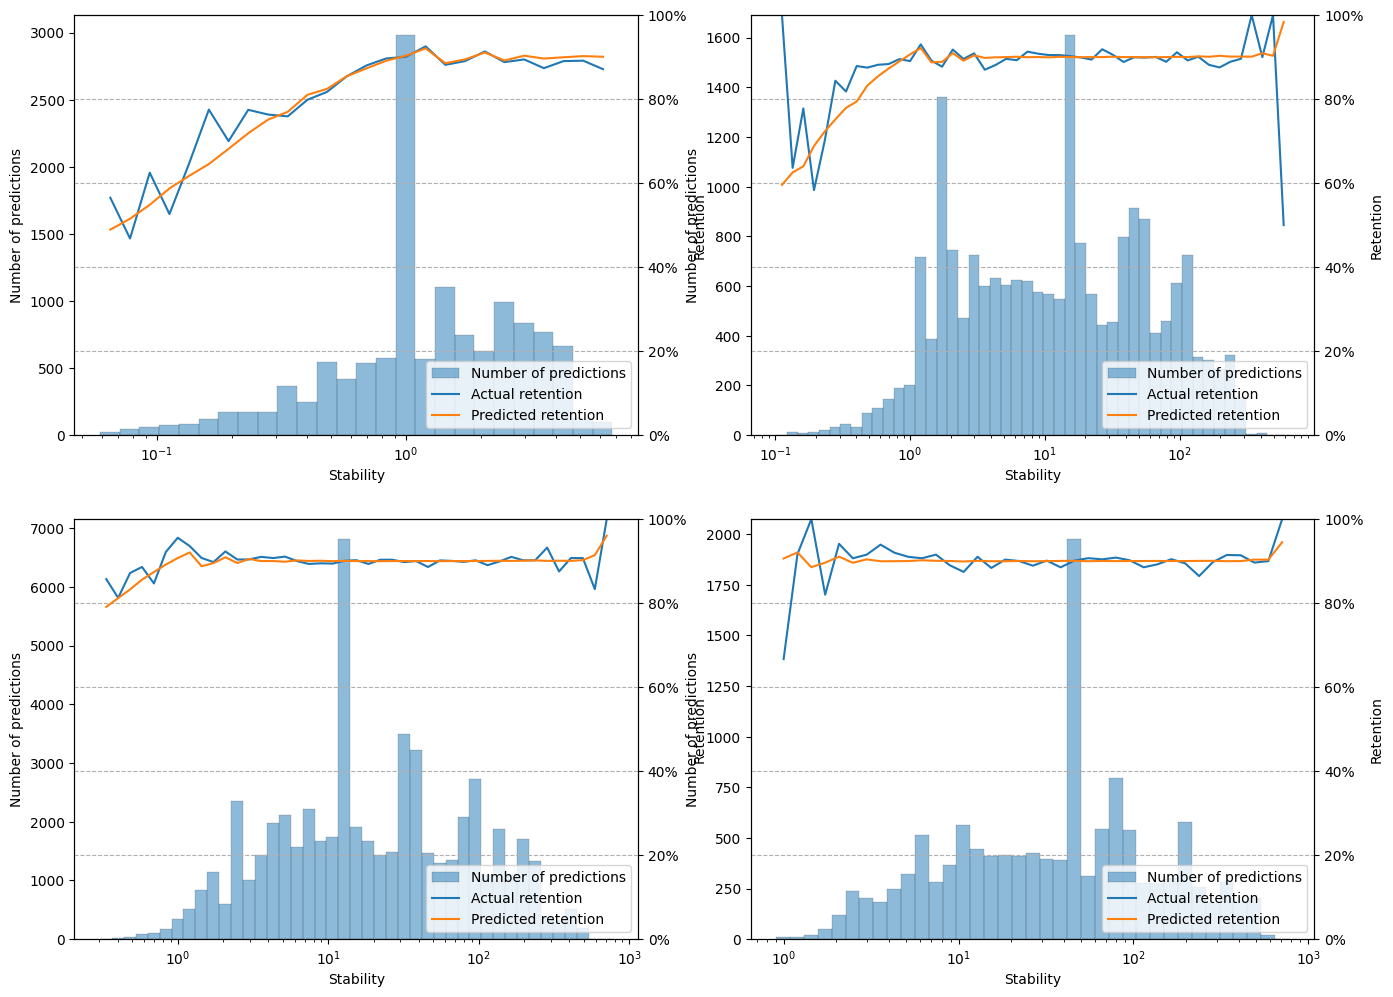

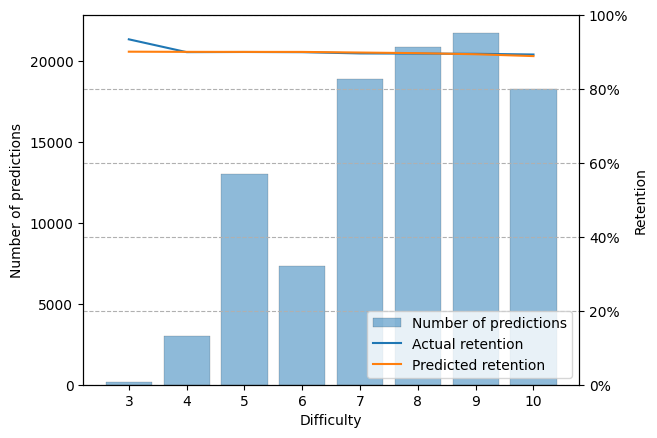

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

In [5]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.001921 -0.001392 -0.000211 -0.000237 -0.000039  0.000017]
RMSE(bins) (trained - ideal): [-0.002732 -0.001806 -0.000799 -0.000901 -0.00023   0.000121]
AUC (trained - ideal): [ 0.023463  0.022075  0.002801  0.001096  0.000996 -0.001721]


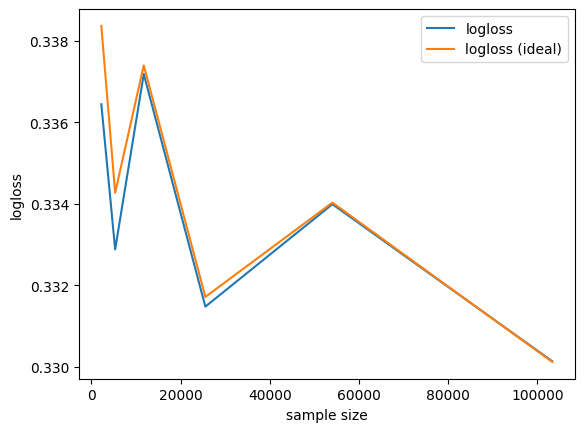

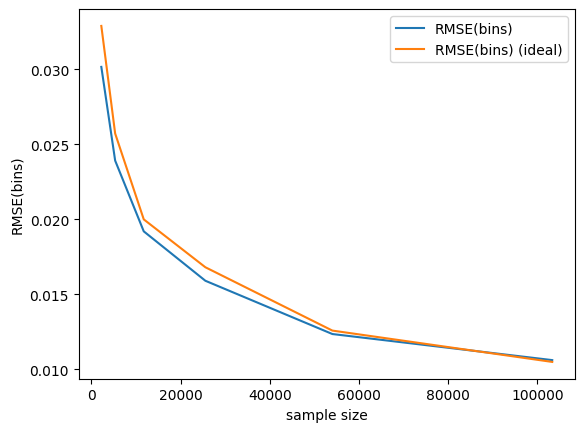

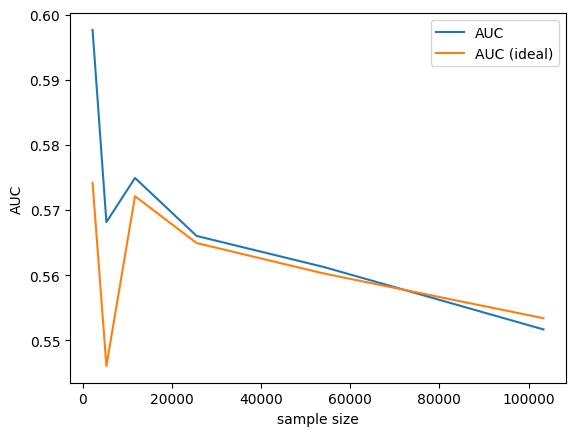

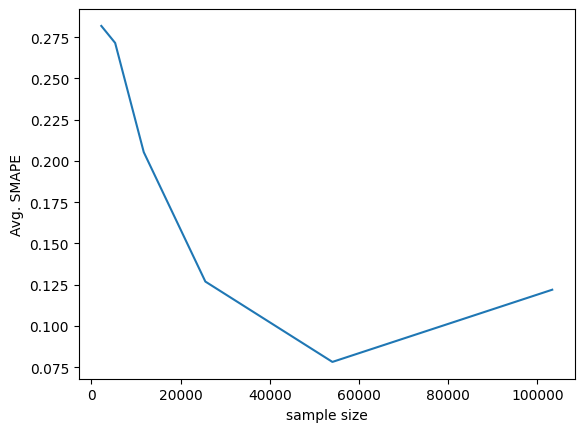

In [6]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
